# Step 0: Initial setup

**NOTE:** 
* Following tasks must be performed each time the notebook instance is started.
* This is **NOT** required when the Kernel is restarted.

**NOTE:** Installation of `jupyter_bokeh` may take a while

In [ ]:
conda install -c conda-forge pyod jupyter_bokeh

# Step 1: Basic setup

**NOTE:** Start here when you restarted your Kernel **ONLY**.

## Step 1.1: Imports

In [1]:
import sys
import os
from datetime import datetime
from pathlib import Path

# importing forecast notebook utility from notebooks/common directory
sys.path.insert(0, os.path.abspath("./common/"))
import util
import util.fcst_utils

%reload_ext autoreload
import boto3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 5.0)

pd.options.mode.copy_on_write = True

from bokeh.io import output_notebook
from bokeh.plotting import show

output_notebook()

Loading BokehJS ...

## Step 1.2: Setup variables

In [12]:
# Resource tag values
owner = "martin.macecek@rearc.io"
type = "Internal"
usage = "Playground"

# Custom variables
prefix = "mac-training"
role_name = f"{prefix}-forecasting"
bucket_name = f"{prefix}-bucket-275279264324-us-east-1"
path = "forecasting/input"
data_key = f"{path}/RIVN.csv"
future_data_key = f"{path}/RIVN_20240513.csv"
prepared_data_key_prefix = "forecasting/prepared/rivn"
item_id = "RIVN"
target_column_name = "close"
domain="RETAIL"

# Setup more variables
s3_target_data_key = f"s3://{bucket_name}/{prepared_data_key_prefix}.csv"
s3_related_data_key = f"s3://{bucket_name}/{prepared_data_key_prefix}_rts.csv"
date_format = '%Y%m%d_%H%M%S'
ui_date_format = '%a, %d %b %Y %H:%M:%S %Z'

# Tags for resource tagging
tags = [{'Key': 'Owner', 'Value': owner},
        {'Key': 'Type', 'Value': type},
        {'Key': 'Usage', 'Value': usage}]

# Forecast
# Forecast length in days (Units is defined below)
FORECAST_LENGTH = 30

# What is your forecast time unit granularity?
# Choices are: ^Y|M|W|D|h|30min|15min|10min|5min|1min$
DATASET_FREQUENCY = "D"
DATASET_TIMESTAMP_FORMAT = "yyyy-MM-dd"
# delimiter = ','

# What name do you want to give this project?
# We will use this same name for your Forecast Dataset Group name.
PROJECT = 'rivn-forecast'
DATA_VERSION = 9

# Whether or not to use other features of target dataet (e.g. high, low, open...)
USE_OTHER_FEATURES = True
# Whether or not to use bank days, which creates another features indicating a trading day or not
USE_BANK_DAY = False
# Whether or not to fill missing data (typically non-trading days (weekends and holidays))
FILL_MISSING_DATA = False

## Step 1.3: API connectivity

In [3]:
region = boto3.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')
print(f"Account: {account_id}, Region: {region}")

Account: 275279264324, Region: us-east-1


In [4]:
# Connect API sessions
session = boto3.Session(region_name=region) 
s3 = session.client(service_name='s3')
forecast = session.client(service_name='forecast')
forecastquery = session.client(service_name='forecastquery')

## Step 1.4: AWS resources

In [5]:
# Create or retrieve the role to provide to Amazon Forecast.
role_arn = util.get_or_create_iam_role(role_name=role_name)

# echo user inputs without account
print(f"Success! Role '{role_arn.split('/')[1]}' ready for use.")

The role mac-training-forecasting exists, skipping creation...
Done.
Success! Role 'mac-training-forecasting' ready for use.


In [6]:
util.get_or_create_bucket(bucket_name, region=region)
print(f"Success! Bucket '{bucket_name}' ready for use.")

Success! Bucket 'mac-training-bucket-275279264324-us-east-1' ready for use.


# Step 2: Data preparation

In [7]:
stock_df = util.prepare_data(
    bucket_name,
    data_key,
    "%m/%d/%Y",
    target_column_name,
    item_id,
    fill_missing_values=FILL_MISSING_DATA,
    use_bank_day=USE_BANK_DAY)
stock_df.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:275: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


,timestamp,close,open,high,low,item_id
0,2024-05-13,10.90,10.04,11.19,10.04,RIVN
1,2024-05-10,9.99,10.20,10.40,9.84,RIVN
2,2024-05-09,10.22,10.25,10.47,10.04,RIVN
3,2024-05-08,10.27,9.51,10.28,9.25,RIVN
4,2024-05-07,10.25,11.14,11.22,10.07,RIVN


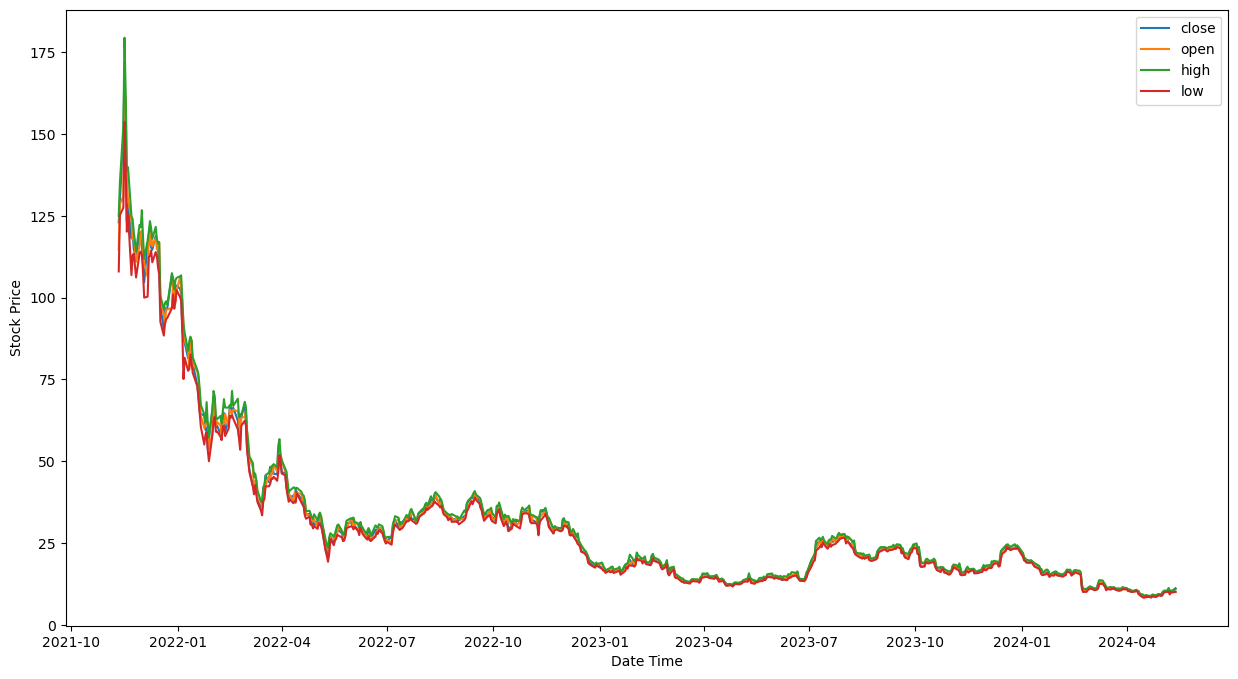

In [8]:
stock_df.plot(x='timestamp', y=[target_column_name, 'open', 'high', 'low'], figsize=(15, 8))
plt.xlabel('Date Time')
plt.ylabel('Stock Price')
plt.show()

In [9]:
stock_df.timestamp.min()

datetime.date(2021, 11, 11)

In [10]:
related_data=util.get_related_data(
    s3_client=s3,
    bucket=bucket_name,
    prefix=path,
    target_df=stock_df,
    target_column_name=target_column_name,
    item_id=item_id,
    exclude=[data_key, future_data_key],
    fill_missing_values=FILL_MISSING_DATA,
    use_bank_day=USE_BANK_DAY,
    extra_features=USE_OTHER_FEATURES,
    start_date=stock_df.timestamp.min(),
    end_date=stock_df.timestamp.max()
)
related_data

,timestamp,open,high,low,item_id,lcid_close,nkla_close,tsla_close
0,2024-05-13,10.04,11.19,10.04,RIVN,2.81,0.5499,171.89
1,2024-05-10,10.20,10.40,9.84,RIVN,2.66,0.5370,168.47
2,2024-05-09,10.25,10.47,10.04,RIVN,2.70,0.5760,171.97
3,2024-05-08,9.51,10.28,9.25,RIVN,2.71,0.5791,174.72
4,2024-05-07,11.14,11.22,10.07,RIVN,2.62,0.6029,177.81
...,...,...,...,...,...,...,...,...
623,2021-11-17,160.88,163.00,140.35,RIVN,52.55,13.3900,363.00
624,2021-11-16,163.80,179.47,153.78,RIVN,55.52,13.3600,351.58
625,2021-11-15,130.80,152.53,127.51,RIVN,44.88,13.7300,337.80
626,2021-11-12,128.65,135.20,125.25,RIVN,43.93,13.9800,344.47


# Step 3: Prepare and Save the Target Time Series

In [11]:
target_df = stock_df[["timestamp", "item_id", target_column_name]]
target_df.head(5)

,timestamp,item_id,close
0,2024-05-13,RIVN,10.90
1,2024-05-10,RIVN,9.99
2,2024-05-09,RIVN,10.22
3,2024-05-08,RIVN,10.27
4,2024-05-07,RIVN,10.25


In [13]:
rts_df = related_data
rts_df.head(5)

,timestamp,open,high,low,item_id,lcid_close,nkla_close,tsla_close
0,2024-05-13,10.04,11.19,10.04,RIVN,2.81,0.5499,171.89
1,2024-05-10,10.20,10.40,9.84,RIVN,2.66,0.5370,168.47
2,2024-05-09,10.25,10.47,10.04,RIVN,2.70,0.5760,171.97
3,2024-05-08,9.51,10.28,9.25,RIVN,2.71,0.5791,174.72
4,2024-05-07,11.14,11.22,10.07,RIVN,2.62,0.6029,177.81


In [14]:
print(f"{len(target_df)} = {len(rts_df)}")
assert len(target_df) == len(rts_df), "length doesn't match"

628 = 628


In [15]:
target_df.to_csv(s3_target_data_key, index= False, header = False)
rts_df.to_csv(s3_related_data_key, index= False, header = False)

# Step 4: Create the Dataset Group and Dataset

## Dataset Group

In [16]:
dataset_group_name = f"{prefix}_{PROJECT}_{DATA_VERSION}".replace("-", "_")
print(f"Dataset Group Name = {dataset_group_name}")

Dataset Group Name = mac_training_rivn_forecast_9


In [17]:
dataset_arns = []
try:
    create_dataset_group_response = \
        forecast.create_dataset_group(Domain=domain,
                                      DatasetGroupName=dataset_group_name,
                                      DatasetArns=dataset_arns,
                                      Tags=tags
                                     )
    dataset_group_arn = create_dataset_group_response['DatasetGroupArn']
    status = util.wait(lambda: forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn))
    assert status
except forecast.exceptions.ResourceAlreadyExistsException:
    dataset_group_arn = f"arn:aws:forecast:{region}:{account_id}:dataset-group/{dataset_group_name}"
    print(f"Dataset group {dataset_group_arn} already exists.")

ACTIVE 


## Target Schema

In [18]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
tts_schema = {
   "Attributes": util.get_schema_attributes(target_df, domain, target_column_name)
}
tts_schema

{'Attributes': [{'AttributeName': 'timestamp', 'AttributeType': 'timestamp'},
  {'AttributeName': 'item_id', 'AttributeType': 'string'},
  {'AttributeName': 'demand', 'AttributeType': 'float'}]}

## Target Dataset

In [19]:
tts_dataset_name = f"{dataset_group_name}_tts"
print(tts_dataset_name)

mac_training_rivn_forecast_9_tts


In [20]:
try:
    create_dataset_tts_response = \
        forecast.create_dataset(Domain=domain,
                                DatasetType='TARGET_TIME_SERIES',
                                DatasetName=tts_dataset_name,
                                DataFrequency=DATASET_FREQUENCY,
                                Schema=tts_schema,
                                Tags=tags
                               )
    tts_dataset_arn = create_dataset_tts_response['DatasetArn']
    status = util.wait(lambda: forecast.describe_dataset(DatasetArn=tts_dataset_arn))
    assert status
except forecast.exceptions.ResourceAlreadyExistsException:
    tts_dataset_arn = f"arn:aws:forecast:{region}:{account_id}:dataset/{tts_dataset_name}"
    print(f"Target dataset {tts_dataset_arn} already exists.")

ACTIVE 


## Related schema

In [21]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
rts_schema = {
   "Attributes": util.get_schema_attributes(rts_df, domain, target_column_name)
}
rts_schema

{'Attributes': [{'AttributeName': 'timestamp', 'AttributeType': 'timestamp'},
  {'AttributeName': 'open_value', 'AttributeType': 'float'},
  {'AttributeName': 'high_value', 'AttributeType': 'float'},
  {'AttributeName': 'low_value', 'AttributeType': 'float'},
  {'AttributeName': 'item_id', 'AttributeType': 'string'},
  {'AttributeName': 'lcid_close_value', 'AttributeType': 'float'},
  {'AttributeName': 'nkla_close_value', 'AttributeType': 'float'},
  {'AttributeName': 'tsla_close_value', 'AttributeType': 'float'}]}

## Related dataset

In [22]:
rts_dataset_name = f"{dataset_group_name}_rts"
print(rts_dataset_name)

mac_training_rivn_forecast_9_rts


In [23]:
try:
    create_dataset_rts_response = \
        forecast.create_dataset(Domain=domain,
                                DatasetType='RELATED_TIME_SERIES',
                                DatasetName=rts_dataset_name,
                                DataFrequency=DATASET_FREQUENCY,
                                Schema=rts_schema,
                                Tags=tags
                               )
    rts_dataset_arn = create_dataset_rts_response['DatasetArn']
    status = util.wait(lambda: forecast.describe_dataset(DatasetArn=rts_dataset_arn))
    assert status
except forecast.exceptions.ResourceAlreadyExistsException:
    rts_dataset_arn = f"arn:aws:forecast:{region}:{account_id}:dataset/{rts_dataset_name}"
    print(f"Related dataset {rts_dataset_arn} already exists.")

ACTIVE 


In [24]:
dataset_arns = []
dataset_arns.append(tts_dataset_arn)
dataset_arns.append(rts_dataset_arn)
update_dataset_response = forecast.update_dataset_group(DatasetGroupArn=dataset_group_arn, DatasetArns=dataset_arns)
status = util.wait(lambda: forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn))
assert status

ACTIVE 


# Step 5: Import data from S3 to Forecast

## Target data

**Note:** Depending on the data size, the import can take 10 mins or more to become **ACTIVE**.

In [25]:
import_tts_dataset_response = True
if len(util.get_dataset_import_jobs(tts_dataset_arn, forecast)) > 0:
    print("Target dataset has already imported data.")
    import_tts_dataset_response = True if input("Re-import (y/N)? ").lower() == "y" else False

if import_tts_dataset_response:
    tts_dataset_import_job_response = \
        forecast.create_dataset_import_job(DatasetImportJobName=f"tts_job_{datetime.now().strftime(date_format)}",
                                           DatasetArn=tts_dataset_arn,
                                           DataSource={
                                             "S3Config": {
                                                 "Path": s3_target_data_key,
                                                 "RoleArn": role_arn
                                             }
                                           },
                                           TimestampFormat=DATASET_TIMESTAMP_FORMAT,
                                           Tags=tags
                                          )
    tts_dataset_import_job_arn=tts_dataset_import_job_response['DatasetImportJobArn']
    status = util.wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=tts_dataset_import_job_arn))
    assert status
    print("Target data imported.")
else:
    print("Target data re-import skipped")

CREATE_PENDING 
CREATE_IN_PROGRESS .....................................
ACTIVE 
Target data imported.


## Related data

**Note:** Depending on the data size, the import can take 10 mins or more to become **ACTIVE**.

In [26]:
import_rts_dataset_response = True
if len(util.get_dataset_import_jobs(rts_dataset_arn, forecast)) > 0:
    print("Related dataset has already imported data.")
    import_rts_dataset_response = True if input("Re-import (y/N)? ").lower() == "y" else False

if import_rts_dataset_response:
    rts_dataset_import_job_response = \
        forecast.create_dataset_import_job(DatasetImportJobName=f"rts_job_{datetime.now().strftime(date_format)}",
                                           DatasetArn=rts_dataset_arn,
                                           DataSource= {
                                             "S3Config" : {
                                                 "Path": s3_related_data_key,
                                                 "RoleArn": role_arn
                                             } 
                                           },
                                           TimestampFormat=DATASET_TIMESTAMP_FORMAT,
                                           Tags=tags
                                          )
    rts_dataset_import_job_arn = rts_dataset_import_job_response["DatasetImportJobArn"]
    status = util.wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=rts_dataset_import_job_arn))
    assert status
    print("Related data imported.")
else:
    print("Related data re-import skipped")

CREATE_PENDING ..
CREATE_IN_PROGRESS ...........
ACTIVE 
Related data imported.


# Step 6: Training and Evaluation

## DeepAR+

In [ ]:
algorithm_arn = 'arn:aws:forecast:::algorithm/'
algorithm = 'Deep_AR_Plus'
algorithm_arn_deep_ar_plus = algorithm_arn + algorithm
predictor_name_deep_ar = f"{dataset_group_name}_{algorithm.lower()}"
print(f"Predictor Name = {predictor_name_deep_ar}")

**NOTE:** Training a forecast model can take several hours to become **ACTIVE**.

In [ ]:
retrain_predictor_deep_ar = False
existing_predictor_deep_ar = util.get_predictor(predictor_name_deep_ar, forecast)

if existing_predictor_deep_ar:
    predictor_arn_deep_ar = existing_predictor_deep_ar['PredictorArn']
    print(f"DeepAR+ Predictor {predictor_arn_deep_ar} already exists.")
    retrain_predictor_deep_ar = True if input("Retrain model (y/N)? ").lower() == "y" else False

if existing_predictor_deep_ar and retrain_predictor_deep_ar:
    util.delete_forecasts_by_predictor(predictor_arn_deep_ar, forecast)
    print(f"Deleting DeepAR+ Predictor {predictor_arn_deep_ar}...")
    util.wait_till_delete(lambda: forecast.delete_predictor(PredictorArn=predictor_arn_deep_ar))
elif existing_predictor_deep_ar and not retrain_predictor_deep_ar:
    print(f"Keeping existing DeepAR+ Predictor {predictor_arn_deep_ar}.")

if not existing_predictor_deep_ar or retrain_predictor_deep_ar:
    create_predictor_deep_ar_response = \
        forecast.create_predictor(PredictorName=predictor_name_deep_ar,
                                  AlgorithmArn=algorithm_arn_deep_ar_plus,
                                  ForecastHorizon=FORECAST_LENGTH,
                                  PerformAutoML=False,
                                  PerformHPO=False,
                                  InputDataConfig={
                                      "DatasetGroupArn": dataset_group_arn,
                                      "SupplementaryFeatures": [
                                          {"Name": "holiday",
                                           "Value": "US"}],
                                  },
                                  FeaturizationConfig={"ForecastFrequency": DATASET_FREQUENCY},
                                  Tags=tags
                                 )
    predictor_arn_deep_ar = create_predictor_deep_ar_response['PredictorArn']
    print(f"Creating DeepAR+ Predictor {predictor_arn_deep_ar}...")
    status = util.wait(lambda: forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar))
    assert status

## Prophet

In [ ]:
algorithm_arn = 'arn:aws:forecast:::algorithm/'
algorithm = 'Prophet'
algorithm_arn_prophet = algorithm_arn + algorithm
predictor_name_prophet = f"{dataset_group_name}_{algorithm.lower()}"
print(f"Predictor Name = {predictor_name_prophet}")

**NOTE:** Training a forecast model can take several hours to become **ACTIVE**.

In [ ]:
retrain_predictor_prophet = False
existing_predictor_prophet = util.get_predictor(predictor_name_prophet, forecast)

if existing_predictor_prophet:
    predictor_arn_prophet = existing_predictor_prophet['PredictorArn']
    print(f"Prophet Predictor {predictor_arn_prophet} already exists.")
    retrain_predictor_prophet = True if input("Retrain model (y/N)? ").lower() == "y" else False

if existing_predictor_prophet and retrain_predictor_prophet:
    print(f"Deleting Prophet Predictor {predictor_arn_prophet}...")
    util.wait_till_delete(lambda: forecast.delete_predictor(PredictorArn=predictor_arn_prophet))
elif existing_predictor_prophet and not retrain_predictor_prophet:
    print(f"Keeping existing Prophet Predictor {predictor_arn_prophet}.")

if not existing_predictor_prophet or retrain_predictor_prophet:
    create_predictor_response = \
        forecast.create_predictor(PredictorName=predictor_name_prophet,
                                  AlgorithmArn=algorithm_arn_prophet,
                                  ForecastHorizon=FORECAST_LENGTH,
                                  PerformAutoML=False,
                                  PerformHPO=False,
                                  InputDataConfig= {
                                      "DatasetGroupArn": dataset_group_arn,
                                      "SupplementaryFeatures": [
                                          {"Name": "holiday",
                                           "Value": "US"}],
                                  },
                                  FeaturizationConfig={"ForecastFrequency": DATASET_FREQUENCY},
                                  Tags=tags
                                 )
    predictor_arn_prophet = create_predictor_response['PredictorArn']
    print(f"Creating Prophet Predictor {predictor_arn_prophet}...")
    status = util.wait(lambda: forecast.describe_predictor(PredictorArn=predictor_arn_prophet))
    assert status

## Auto

In [27]:
predictor_name_auto = f"{dataset_group_name}_auto"
print(f"Predictor Name = {predictor_name_auto}")

Predictor Name = mac_training_rivn_forecast_9_auto


**NOTE:** Training a forecast model can take several hours to become **ACTIVE**.

In [28]:
existing_predictor_auto = util.get_predictor(predictor_name_auto, forecast)
if existing_predictor_auto:
    predictor_arn_auto = existing_predictor_auto['PredictorArn']
    print(f"Auto Predictor {predictor_arn_auto} already exists.")
    if input("Retrain model (y/N)? ").lower() == "y":
        args = {
            "PredictorName": f"{predictor_name_auto}_retrain_{datetime.now().strftime(date_format)}",
            "ReferencePredictorArn": predictor_arn_auto
        }
    else:
        args = {}
else:
    args = {
        "PredictorName": predictor_name_auto,
        "ForecastHorizon": FORECAST_LENGTH,
        "ForecastFrequency": DATASET_FREQUENCY,
        "DataConfig": {
            "DatasetGroupArn": dataset_group_arn,
            "AdditionalDatasets": [
                {
                    "Name": "holiday",
                    "Configuration": {
                        "CountryCode": ["US"]
                    }
                }
            ]
        },
        "Tags": tags
    }

if args:
    create_predictor_auto_response = forecast.create_auto_predictor(**args)
    predictor_arn_auto = create_predictor_auto_response['PredictorArn']
    print(f"{'Retraining existing' if existing_predictor_auto else 'Creating new'} Auto Predictor {predictor_arn_auto}...")
    status = util.wait(lambda: forecast.describe_auto_predictor(PredictorArn=predictor_arn_auto))
    assert status
else:
    print(f"Keeping existing Auto Predictor {predictor_arn_auto}.")

Creating new Auto Predictor arn:aws:forecast:us-east-1:275279264324:predictor/mac_training_rivn_forecast_9_auto_01HYY5ZDXGPW3Z03PDRC3K5K1X...
CREATE_PENDING 
CREATE_IN_PROGRESS .......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Step 7: Predictor Error Metrics

In [ ]:
error_metrics_deep_ar_plus = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_deep_ar)

In [ ]:
error_metrics_prophet = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_prophet)

In [29]:
error_metrics_auto = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_auto)

In [ ]:
def extract_summary_metrics(metric_response, predictor_name):
    df = pd.DataFrame(metric_response['PredictorEvaluationResults']
                 [0]['TestWindows'][0]['Metrics']['WeightedQuantileLosses'])
    df['Predictor'] = predictor_name
    return df

In [ ]:
deep_ar_metrics = extract_summary_metrics(error_metrics_deep_ar_plus, "DeepAR")
prophet_metrics = extract_summary_metrics(error_metrics_prophet, "Prophet")
auto_metrics = extract_summary_metrics(error_metrics_auto, "Auto")

In [ ]:
pd.concat([deep_ar_metrics, prophet_metrics, auto_metrics]) \
    .pivot(index='Quantile', columns='Predictor', values='LossValue').plot.bar()

# Step 8: Forecasting

## DeepAR+

**NOTE:** Creating a forecast can take up to an hour to become **ACTIVE**.

In [ ]:
forecast_arn_deep_ar = util.create_forecast(
    *util.create_forecast_name(dataset_group_name,
                               'deep_ar',
                               date_format=date_format
                              ),
    predictor_arn_deep_ar,
    forecast,
    tags,
    ui_date_format=ui_date_format,
)

## Prophet

**NOTE:** Creating a forecast can take up to an hour to become **ACTIVE**.

In [ ]:
forecast_arn_prophet = util.create_forecast(
    *util.create_forecast_name(dataset_group_name,
                               'prophet',
                               date_format=date_format
                              ),
    predictor_arn_prophet,
    forecast,
    tags,
    ui_date_format=ui_date_format,
)

## Auto

**NOTE:** Creating a forecast can take up to an hour to become **ACTIVE**.

In [30]:
forecast_arn_auto = util.create_forecast(
    *util.create_forecast_name(dataset_group_name,
                               'auto',
                               date_format=date_format
                              ),
    predictor_arn_auto,
    forecast,
    tags,
    ui_date_format=ui_date_format,
)

Creating new forecast arn:aws:forecast:us-east-1:275279264324:forecast/mac_training_rivn_forecast_9_auto_20240528_024856 for predictor arn:aws:forecast:us-east-1:275279264324:predictor/mac_training_rivn_forecast_9_auto_01HYY5ZDXGPW3Z03PDRC3K5K1X...
CREATE_PENDING 
CREATE_IN_PROGRESS .......................................................................................................................................................................
ACTIVE 


# Step 9: Querying

In [31]:
exact = pd.read_csv(s3_target_data_key, header=None, thousands=',')
exact.columns = ['timestamp', 'item_id', target_column_name]
exact = exact.loc[exact['item_id'] == item_id]
exact

,timestamp,item_id,close
0,2024-05-13,RIVN,10.90
1,2024-05-10,RIVN,9.99
2,2024-05-09,RIVN,10.22
3,2024-05-08,RIVN,10.27
4,2024-05-07,RIVN,10.25
...,...,...,...
623,2021-11-17,RIVN,146.07
624,2021-11-16,RIVN,172.01
625,2021-11-15,RIVN,149.36
626,2021-11-12,RIVN,129.95


In [32]:
exact = util.load_exact_sol(s3_target_data_key, item_id, target_col_name=target_column_name)
exact

,timestamp,item_id,close
0,2024-05-13,RIVN,10.90
1,2024-05-10,RIVN,9.99
2,2024-05-09,RIVN,10.22
3,2024-05-08,RIVN,10.27
4,2024-05-07,RIVN,10.25
...,...,...,...
623,2021-11-17,RIVN,146.07
624,2021-11-16,RIVN,172.01
625,2021-11-15,RIVN,149.36
626,2021-11-12,RIVN,129.95


In [33]:
future_df = util.prepare_data(
    bucket_name,
    future_data_key,
    "%m/%d/%Y",
    target_column_name,
    item_id,
    fill_missing_values=FILL_MISSING_DATA,
    use_bank_day=USE_BANK_DAY,
    minimal=True)
future_df

,timestamp,close,item_id
0,2024-05-24,10.44,RIVN
1,2024-05-23,9.95,RIVN
2,2024-05-22,10.70,RIVN
3,2024-05-21,10.05,RIVN
4,2024-05-20,10.28,RIVN
5,2024-05-17,10.50,RIVN
6,2024-05-16,10.13,RIVN
7,2024-05-15,10.20,RIVN
8,2024-05-14,11.19,RIVN
9,2024-05-13,10.90,RIVN


## DeepAR+

In [ ]:
forecasts_deep_ar = util.query_forecasts(
    util.get_relevant_forecasts(f"{prefix}_{PROJECT}_", DATA_VERSION, "deep_ar", forecast), item_id, forecastquery
)

In [ ]:
forecast_deep_ar_dfs = util.query_results_to_dataframes(forecasts_deep_ar, fill_missing_values=FILL_MISSING_DATA)

### Plot using bokeh

In [ ]:
for key in forecast_deep_ar_dfs:
    auto_plot = util.plot_bokeh_forecasts(
        forecast_deep_ar_dfs[key],
        exact,
        freq=f'1{DATASET_FREQUENCY}',
        forecastHorizon=FORECAST_LENGTH,
        time_back=30,
        future=future_df,
        target_col_name=target_column_name,
        reverse=True,
        title=f"Stock Price Forecast for {item_id} (Auto v{key})"
    )
    show(auto_plot)

## Prophet

In [ ]:
forecasts_prophet = util.query_forecasts(
    util.get_relevant_forecasts(f"{prefix}_{PROJECT}_", DATA_VERSION, "prophet", forecast), item_id, forecastquery
)

In [ ]:
forecast_prophet_dfs = util.query_results_to_dataframes(forecasts_prophet, fill_missing_values=FILL_MISSING_DATA)

### Plot using bokeh

In [ ]:
for key in forecast_prophet_dfs:
    auto_plot = util.plot_bokeh_forecasts(
        forecast_prophet_dfs[key],
        exact,
        freq=f'1{DATASET_FREQUENCY}',
        forecastHorizon=FORECAST_LENGTH,
        time_back=30,
        future=future_df,
        target_col_name=target_column_name,
        reverse=True,
        title=f"Stock Price Forecast for {item_id} (Auto v{key})"
    )
    show(auto_plot)

## Auto

In [34]:
forecasts_auto = util.query_forecasts(
    util.get_relevant_forecasts(f"{prefix}_{PROJECT}_", DATA_VERSION, "auto", forecast), item_id, forecastquery
)

In [35]:
forecast_auto_dfs = util.query_results_to_dataframes(forecasts_auto, fill_missing_values=FILL_MISSING_DATA)

In [43]:
print(len(forecast_auto_dfs[9]['p10']))
print(len(forecast_auto_dfs[9]['p50']))
print(len(forecast_auto_dfs[9]['p90']))

21
21
22


In [48]:
p10_df = pd.DataFrame(forecasts_auto[9]['Predictions']['p10'])
p10_df

,Timestamp,Value
0,2024-05-14T00:00:00,9.044332
1,2024-05-15T00:00:00,8.408529
2,2024-05-16T00:00:00,8.290189
3,2024-05-17T00:00:00,8.092051
4,2024-05-18T00:00:00,-0.083817
5,2024-05-19T00:00:00,-0.071695
6,2024-05-20T00:00:00,8.239873
7,2024-05-21T00:00:00,8.114912
8,2024-05-22T00:00:00,7.642391
9,2024-05-23T00:00:00,7.538960


In [ ]:
conda install -c conda-forge pyod

Retrieving notices: ...working... done
Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::autopep8==2.0.4=pyhd8ed1ab_0
  - conda-forge/linux-64::black==24.3.0=py310hff52083_0
  - conda-forge/noarch::bleach==6.1.0=pyhd8ed1ab_0
  - conda-forge/noarch::plotly==5.19.0=pyhd8ed1ab_0
  - conda-forge/noarch::pytest==8.1.1=pyhd8ed1ab_0
  - conda-forge/noarch::qtpy==2.4.1=pyhd8ed1ab_0
  - conda-forge/linux-64::sip==6.7.12=py310hc6cd4ac_0
  - conda-forge/noarch::flask==3.0.2=pyhd8ed1ab_0
  - conda-forge/noarch::importlib_metadata==7.1.0=hd8ed1ab_0
  - conda-forge/linux-64::pyqt5-sip==12.12.2=py310hc6cd4ac_5
  - conda-forge/noarch::pytoolconfig==1.2.5=pyhd8ed1ab_0
  - conda-forge/noarch::qdarkstyle==3.1=pyhd8ed1ab_0
  - conda-forge/noarch::qtawesome==1.3.0=pyh9208f05_0
  - conda-forge/noarch::yapf==0.40.1=pyhd8ed1ab_0
  - conda-forge/noarch::dask-core==2024.3.1=pyhd8ed1ab_0


In [49]:
from pyod.models.knn import KNN

ModuleNotFoundError: No module named 'pyod'

### Plot using bokeh

In [36]:
for key in forecast_auto_dfs:
    auto_plot = util.plot_bokeh_forecasts(
        forecast_auto_dfs[key],
        exact,
        freq=f'1{DATASET_FREQUENCY}',
        forecastHorizon=FORECAST_LENGTH,
        time_back=30,
        future=future_df,
        target_col_name=target_column_name,
        reverse=True,
        title=f"Stock Price Forecast for {item_id} (Auto v{key})"
    )
    show(auto_plot)

# Cleanup

## Datasets and Dataset Group

In [ ]:
util.delete_dataset_group(dataset_group_arn, forecast)
# util.delete_dataset_group("arn:aws:forecast:us-east-1:275279264324:dataset-group/mac_training_rivn_forecast_2", forecast)
# util.delete_predictors("arn:aws:forecast:us-east-1:275279264324:dataset-group/mac_training_rivn_forecast_2", forecast)